# Exploratory Data Analysis

This notebook is an exploratory analysis of the chess games provided in this dataset. We will take a peak at and try to understand all of the fields.

In [1]:
import pandas as pd

games = pd.read_csv("input/games.csv")
games.head(1)

id  rated    created_at  last_move_at  turns victory_status winner  \
0  TZJHLljE  False  1.504210e+12  1.504210e+12     13      outoftime  white   

  increment_code  white_id  white_rating black_id  black_rating  \
0           15+2  bourgris          1500     a-00          1191   

                                               moves opening_eco  \
0  d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...         D10   

                       opening_name  opening_ply  
0  Slav Defense: Exchange Variation            5

## Turns taken

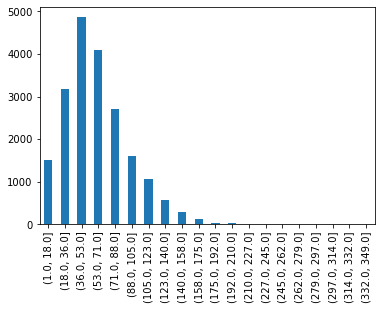

In [2]:
pd.cut(games['turns'], 20, precision=0).value_counts().sort_index().plot.bar()

The number of turns taken per game follows a normal distribution with a small positive skew towards longer games. Games are **60 turns** long on average. Note that for the purposes of this variable, each player move is a turn.

In [3]:
games['turns'].mean(), games['turns'].median()

(60.46599860404826, 55.0)

## Victory status

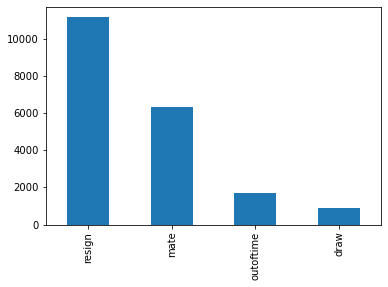

In [4]:
games['victory_status'].value_counts().plot.bar()

Most games end with a player resigning. It seems that many players do not stick around for the mate, prefering to insteal move on to the next game.

## Winner color

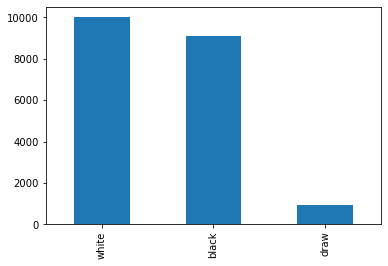

In [5]:
games['winner'].value_counts().plot.bar()

White famously has a slight first-mover advantage in chess, as demonstrated here.

## Increment code

This variable controls the timer that the game is played under. In timed chess games (most online chess games are timed, for obvious reasons) each player is afforded a time basis (10 minutes, 15 minutes, etc.) awarded at the beginning of the game and an increment (15 seconds etc.) awarded every time a turn starts. If the player runs the clock out, they lose the game.

This field is populated by strings in the form `15+2`. The first number, `15`, is the time basis in minutes; the second number, `2`, is the increment in seconds.

## Ratings

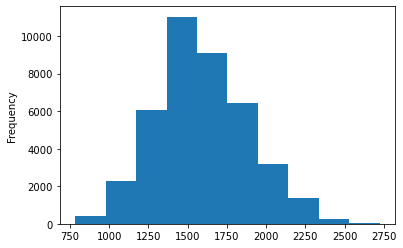

In [6]:
pd.concat([games['white_rating'], games['black_rating']]).plot.hist(20)

Ratings are normally distributed.

In [7]:
import numpy as np
pd.concat([games['white_rating'], games['black_rating']]).agg([np.mean, np.median])

mean      1592.731927
median    1564.000000
dtype: float64

## Openings

The `opening_eco` variable is the control code from the Encyclopedia of Chess Openings for the opening in question, basically an ID code for the human-readable name historically assigned to the opening and contained in `opening_name`.

Openings are sequences of moves by both black and white at the beginning of a chess game that are well-known enough to be "in the book". At the present time effectively every possible sequence of opening moves has been studied. In this dataset openings are provided with the following naming convention:

`Name of Opening: Basic Variation Name | Continuation Name | Continuation Name`

Hence some example values are:

```
Van't Kruijs Opening
Sicilian Defense: Bowdler Attack
Queen's Gambit Accepted: Normal Variation |  Traditional System
Pirc Defense: Classical Variation |  Quiet System |  Chigorin Line
```

You can see the kinds of values provided in this field for yourself:

In [8]:
games['opening_name'].value_counts()

Van't Kruijs Opening                                                    368
Sicilian Defense                                                        358
Sicilian Defense: Bowdler Attack                                        296
French Defense: Knight Variation                                        271
Scotch Game                                                             271
                                                                       ... 
Queen's Pawn Game: Veresov Attack |  Boyce Defense                        1
Philidor Defense: Alapin-Blackburne Gambit                                1
Queen's Indian Defense: Classical Variation |  Traditional Variation      1
King's Gambit Accepted |  Kieseritzky Gambit |  Berlin Defense            1
Dutch Defense: Staunton Gambit                                            1
Name: opening_name, Length: 1477, dtype: int64

The `Van't Kruijs Opening` is actually a highly irregular opening move, but appears first in this list for ontological reasons. Common lines, like the Sicilian Defense, are provided with a variety of variations. Uncommon lines, which have been less studied, and therefore have fewer variations named, will appear more often in a value count simply because they haven't been "broken up" as much. Splitting off the subcategories we get something that is much more in line with what we expected:

In [9]:
games['opening_name'].map(lambda n: n.split("|")[0].split(":")[0]).value_counts().head(10)

Sicilian Defense        2573
French Defense          1306
Queen's Pawn Game       1059
Italian Game             981
King's Pawn Game         917
Ruy Lopez                858
English Opening          720
Scandinavian Defense     716
Caro-Kann Defense        593
Scotch Game              465
Name: opening_name, dtype: int64

In [10]:
games[games['opening_name'] == 'Sicilian Defense']['opening_ply'].value_counts()

4    171
2    151
3     20
5     16
Name: opening_ply, dtype: int64

`opening_ply` is an interesting field because it states to how many `moves` the studied opening line holds. For example, note that in the follow 5-ply Sicilian Defense games, the opening sequence is always `e4 c5 Nf3 d6 d4`.

In [11]:
games[((games['opening_name'] == 'Sicilian Defense') & (games['opening_ply'] == 5))].head(3)

id  rated    created_at  last_move_at  turns victory_status  \
270   PEIWrbTQ   True  1.471100e+12  1.471100e+12     29           mate   
4546  nxDsrrWl   True  1.479670e+12  1.479670e+12     37         resign   
5278  btRX748K   True  1.463630e+12  1.463630e+12     67      outoftime   

     winner increment_code         white_id  white_rating        black_id  \
270   white            7+3          eideral          1513         atorius   
4546  white           0+15  drawmeister2015          2013  jopeshdamaster   
5278  white           10+0          reneesh          1709      evan_h1234   

      black_rating                                              moves  \
270           1456  e4 c5 Nf3 d6 d4 Nc6 Bb5 a6 Bxc6+ bxc6 dxc5 Qa5...   
4546          1773  e4 c5 Nf3 d6 d4 Nc6 dxc5 dxc5 Qxd8+ Nxd8 Bb5+ ...   
5278          1334  e4 c5 Nf3 d6 d4 Nc6 Bb5 Bd7 d5 Nb4 Bxd7+ Qxd7 ...   

     opening_eco      opening_name  opening_ply  
270          B54  Sicilian Defense            5  
4546         B54  Sicilian Defense            5  
5278         B54  Sicilian Defense            5

`ply` is a term from game theory. A single ply is an identifiable unit of play which shifts the game's decision tree. In chess, this is every single *move*, that is, every time a piece is moved and the turn is passed to another player. See [the Wikipedia article][1] for more details.

Algebraic notation is a format for describing a sequence of chess moves. In algebraic notation the board is divided into a grid, of ascending letters and numbers. Every piece besides the pawn gets a letter. So for example  `e4 c5 Nf3` means "white pawn to e4, then black pawn to c5, then white knight to f3. And so on. Check out the Wikipedia article on [algebraic notation](https://en.wikipedia.org/wiki/Algebraic_notation).

[1]: https://en.wikipedia.org/wiki/Ply_(game_theory)